In [1]:
# using PlotlyJS
using Plots
using PyCall
using Printf
using LsqFit
using LinearAlgebra
using Statistics
# using Flux
using Random
using DualNumbers
using ForwardDiff
# using Distributed
# using Base.Threads
# using Pkg
# using Optim
gr()  

Plots.GRBackend()

In [34]:
include("XY2.jl")

# Define Chebyshev polyonmials for construction of basis
chebyshevPolynomials::Vector{Function} = [
    x -> 1
    x -> x
    x -> 2*x^2 - 1
    x -> 4*x^3 - 3*x
    x -> 8*x^4 - 8*x^2 + 1
    x -> 16*x^5 - 20*x^3 + 5*x
    x -> 32*x^6 - 48*x^4 + 18*x^2 - 1
    x -> 64*x^7 - 112*x^5 + 56*x^3 - 7*x
    x -> 128*x^8 - 256*x^6 + 160*x^4 - 32*x^2 + 1
]
# Note Julia indexing starts from 1 so chebyshevPolynomials[n] is actually T_n-1 and so forth!

hartreeToWavenumberConversion::Float64 = 2.194746354e5
convertToRadians::Float64 = pi/180

# inputFileName::String = "CS2-AMES-fit-InitialFit"
# inputFileName::String = "CS2-AMES-fit-MorseFitted"
# inputFileName::String = "CS2-AMES-FitStructural"
inputFileName::String = "CS2-AMES-Refit"
# inputFileName::String = "CS2-AMES-fit-InitialFit-1D-Stretch"
# inputFileName::String = "CS2-AMES-fit-InitialFit-1D-StretchFittedMorse"
# inputFileName::String = "CS2-AMES-fit-InitialFit-1D-Alpha"
potentialInputFilePath::String = inputFileName*".inp"

keywords::Vector{String} = ["structural", "linear", "grid"]
inputBlocks::Vector{Vector{String}} = []
open(potentialInputFilePath, "r") do potentialInputFile::IOStream
    input::Vector{String} = readlines(potentialInputFile)
    addToBlock::Bool = false
    for keyword in keywords
        newBlock::Vector{String} = []
        for line in input
            if lowercase(line) == lowercase(keyword)
                addToBlock = true
            elseif lowercase(line) == "end"
                addToBlock = false
            end
            if addToBlock
                push!(newBlock, line)
            end
        end
        push!(inputBlocks, newBlock)
    end
end

structuralParameterBlock::Vector{String} = inputBlocks[1][2:end]
numberOfStructuralParameters::Int64 = size(structuralParameterBlock)[1] - 1
structuralParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(structuralParameterBlock, r"\s+")
numberOfMorseParameters::Int64 = parse(Int64, structuralParameterBlockSplit[1][2])
numberOfEquilibriumParameters::Int64 = numberOfStructuralParameters - numberOfMorseParameters
numberOfModes::Int64 = size(structuralParameterBlockSplit[2])[1] - 3
numberOfAtoms::Int64 = (numberOfModes + 6)/3
numberOfStretches::Int64 = numberOfAtoms - 1
numberOfBondAngles::Int64 = numberOfAtoms - 2
numberOfDihedrals::Int64 = numberOfAtoms - 3

structuralParameters::Vector{Float64} = zeros(numberOfStructuralParameters)
structuralParameterLabels::Vector{String} = []
structuralPowers::Matrix{Int64} = zeros(numberOfStructuralParameters, numberOfModes)
structuralParametersOn::Vector{Int64} = zeros(numberOfStructuralParameters)
for i in 1:numberOfStructuralParameters
    structuralParameters[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end])
    push!(structuralParameterLabels, String(structuralParameterBlockSplit[i + 1][1]))
    structuralPowers[i, :] = parse.(Int64, structuralParameterBlockSplit[i + 1][2:end-2])
    structuralParametersOn[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end - 1])
end

structuralParameters::Vector{Float64} = convertAnglesToRadians(structuralParameters)

linearParameterBlock::Vector{String} = inputBlocks[2][2:end]
numberOfLinearParameters::Int64 = size(linearParameterBlock)[1]
linearParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(linearParameterBlock, r"\s+")

linearParameters::Vector{Float64} = zeros(numberOfLinearParameters)
linearParameterLabels::Vector{String} = []
linearPowers::Matrix{Int64} = zeros(numberOfLinearParameters, numberOfModes)
linearParametersOn::Vector{Int64} = zeros(numberOfLinearParameters)

for i in 1:numberOfLinearParameters
    linearParameters[i] = parse(Float64, linearParameterBlockSplit[i][end])
    push!(linearParameterLabels, String(linearParameterBlockSplit[i][1]))
    linearPowers[i, :] = parse.(Int64, linearParameterBlockSplit[i][2:end-2])
    linearParametersOn[i] = parse(Float64, linearParameterBlockSplit[i][end - 1])
end

allParameters::Vector{Float64} = vcat(structuralParameters, linearParameters)
allParameterLabels::Vector{String} = vcat(structuralParameterLabels, linearParameterLabels)
allPowers::Matrix{Int64} = vcat(structuralPowers, linearPowers)
allParametersOn::Vector{Int64} = vcat(structuralParametersOn, linearParametersOn)
numberOfParameters::Int64 = length(allParameters)
 
gridBlock::Vector{String} = inputBlocks[3][2:end]
numberOfGridPoints::Int64 = size(gridBlock)[1] 
gridBlockSplit::Vector{Vector{SubString{String}}} = split.(gridBlock, r"\s+")

grid::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
gridValenceCoordinates::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
energies::Vector{Float64} = zeros(numberOfGridPoints)

for i in 1:numberOfGridPoints
    grid[i, :]  = parse.(Float64, gridBlockSplit[i][1:numberOfModes])
    gridValenceCoordinates[i, :] = defineInternalCoordinates(grid[i, :])
    energies[i] = parse(Float64, gridBlockSplit[i][numberOfModes+1])
end

referenceGeometry::Vector{Float64} = gridValenceCoordinates[1, :] 

# energies = energies.*hartreeToWavenumberConversion
# minimumEnergy::Float64 = minimum(energies)
println()
# @printf("%12.10f \n", minimumEnergy)
# energies = energies.-minimumEnergy

# Weight factor by Partridge and Schwenke
function computeWeightOfPoint(energy::Float64, energyThreshold=20000.0::Float64, energyMax=10000.0::Float64)::Float64
    weight::Float64 = (tanh(−0.0006*(energy - energyThreshold)) + 1.002002002)/2.002002002
    if energy > energyMax
        weight = weight/(0.0001*energy)
    else
        weight = weight/(0.0001*energyMax)
    end
    return weight
end

weights::Vector{Float64} = computeWeightOfPoint.(energies)
weightsSqrt::Vector{Float64} = sqrt.(weights)

function defineXiGrid(gridValenceCoordinates::Matrix{Float64}, structuralParameters)
    numberOfGridPoints::Int64 = size(gridValenceCoordinates)[1]
    T::DataType = eltype(structuralParameters)
    xiGrid::Matrix{T} = zeros(numberOfGridPoints, numberOfModes)
    for i in 1:numberOfGridPoints
        xiGrid[i, :] = defineXiCoordinates(gridValenceCoordinates[i, :], structuralParameters)
    end
    return xiGrid
end


# For range 1 to -1
# function rescaleXiGrid(xiGrid)
#     xiMaxima = maximum(xiGrid, dims=1)[1, :]
#     xiMinima = minimum(xiGrid, dims=1)[1, :]
#     xiGrid = (2*xiGrid .- (xiMaxima .+ xiMinima)')./(xiMaxima .- xiMinima)'
#     return xiGrid
# end

# For unit variance
function rescaleXiGrid(xiGrid)
    xistd = std(xiGrid, dims=1)[1, :]
    ximean = mean(xiGrid, dims=1)[1, :]
    xiGrid = (xiGrid .- (ximean)')./(xistd)'
    return xiGrid
end


function defineChebyshevBasis(xiGrid)
    numberOfGridPoints::Int64 = size(xiGrid)[1]
    T::DataType = eltype(xiGrid)
    xiMatrix::Matrix{T} = zeros(numberOfGridPoints, numberOfLinearParameters)
    for i in 1:numberOfGridPoints
        for j in 1:numberOfLinearParameters
            xiMatrix[i, j] = chebyshevPolynomials[linearPowers[j, 1]+1](xiGrid[i, 1])*chebyshevPolynomials[linearPowers[j, 2]+1](xiGrid[i, 2])*chebyshevPolynomials[linearPowers[j, 3]+1](xiGrid[i, 3])
            if linearPowers[j, 1] != linearPowers[j, 2]
                xiMatrix[i, j] += chebyshevPolynomials[linearPowers[j, 1]+1](xiGrid[i, 2])*chebyshevPolynomials[linearPowers[j, 2]+1](xiGrid[i, 1])*chebyshevPolynomials[linearPowers[j, 3]+1](xiGrid[i, 3])
            end
        end
    end
    return xiMatrix
end

function definePowersGrid(xiGrid)
    numberOfGridPoints::Int64 = size(xiGrid)[1]
    T::DataType = eltype(xiGrid)
    xiMatrix::Matrix{T} = zeros(numberOfGridPoints, numberOfLinearParameters)
    for i in 1:numberOfGridPoints
        for j in 1:numberOfLinearParameters
            xiMatrix[i, j] = xiGrid[i, 1]^linearPowers[j, 1]*xiGrid[i, 2]^linearPowers[j, 2]*xiGrid[i, 3]^linearPowers[j, 3]
            if linearPowers[j, 1] != linearPowers[j, 2]
                xiMatrix[i, j] += xiGrid[i, 2]^linearPowers[j, 1]*xiGrid[i, 1]^linearPowers[j, 2]*xiGrid[i, 3]^linearPowers[j, 3]
            end
        end
    end
    return xiMatrix
end

function solveLinearRegression(gridValenceCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, structuralParameterIndex, structuralParameterForDerivative, λ::Float64 = 1e-7)
    T::DataType = typeof(structuralParameterForDerivative)
    numberOfGridPoints::Int64 = length(energies)
    structuralParametersInLossFunction::Vector{T} = copy(structuralParameters)
    structuralParametersInLossFunction[structuralParameterIndex] = structuralParameterForDerivative
    xiGrid = defineXiGrid(gridValenceCoordinates, structuralParametersInLossFunction)
    # xiGrid = rescaleXiGrid(xiGrid)
    # xiMatrix = defineChebyshevBasis(xiGrid)
    xiMatrix = definePowersGrid(xiGrid)
    weightsSqrt::Vector{Float64} = sqrt.(weights)
    weightedXiMatrix = xiMatrix .* weightsSqrt
    weightedEnergies = energies .* weightsSqrt
    tikhonovMatrix::Matrix{Float64} = λ.*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters)
    linearParametersOfFit = (weightedXiMatrix'*weightedXiMatrix + tikhonovMatrix)\ (weightedXiMatrix'*weightedEnergies)
    computedEnergies::Vector{T} = xiMatrix*linearParametersOfFit
    residuals::Vector{T} = energies .- computedEnergies
    loss::T = (sum(weights.*residuals.^2) + sum(λ.*linearParametersOfFit.^2))/numberOfGridPoints
    return loss
end

function computeStructuralLoss(gridValenceCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, structuralParameterIndex, structuralParameterForDerivative, λ::Float64 = 1e-7)
    T::DataType = typeof(structuralParameterForDerivative)
    numberOfGridPoints::Int64 = length(energies)
    structuralParametersInLossFunction::Vector{T} = copy(structuralParameters)
    structuralParametersInLossFunction[structuralParameterIndex] = structuralParameterForDerivative
    xiGrid = defineXiGrid(gridValenceCoordinates, structuralParametersInLossFunction)
    # xiGrid = rescaleXiGrid(xiGrid)
    # xiMatrix = defineChebyshevBasis(xiGrid)
    xiMatrix = definePowersGrid(xiGrid)
    computedEnergies::Vector{T} = xiMatrix*linearParameters
    residuals::Vector{T} = energies .- computedEnergies
    loss::T = (sum(weights.*residuals.^2) + sum(λ.*linearParameters.^2))/numberOfGridPoints
    return loss
end

function computeLoss(xiMatrix::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, λ::Float64 = 1e-7)
    numberOfGridPoints::Int64 = length(energies)
    computedEnergies::Vector{Float64} = xiMatrix*linearParameters
    residuals::Vector{Float64} = energies .- computedEnergies
    loss::Float64 = (sum(weights.*residuals.^2) + λ*sum(linearParameters.^2))/numberOfGridPoints
    return loss
end

function computeJacobian(xiMatrix::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, λ::Float64 = 1e-7)
    numberOfGridPoints::Int64 = length(energies)
    computedEnergies::Vector{Float64} = xiMatrix*linearParameters
    residuals::Vector{Float64} = energies .- computedEnergies
    jacobian::Vector{Float64} = 2*(-xiMatrix'*(weights.*residuals) .+ λ.*linearParameters)/numberOfGridPoints
end


structuralParameterBounds::Vector{Vector{Float64}} = [
    [1.55275000 - 0.2, 1.55275000 + 0.2],
    [1.0, 5.0],
]

xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
# xiGrid = rescaleXiGrid(xiGrid)
# xiMatrix::Matrix{Float64} = defineChebyshevBasis(xiGrid)
xiMatrix::Matrix{Float64} = definePowersGrid(xiGrid)

learningRateStructural::Float64 = 1
learningRateLinear::Float64 = 1
ϵ::Float64 = 1e-4 # Regulate weights
λ::Float64 = 1e-8 # Tikhonov Regularization parameter
epochs::Int64 = 100
for epoch in 1:epochs
    structuralParameterGradient::Vector{Float64} = zeros(numberOfStructuralParameters)
    for i in 1:numberOfStructuralParameters
        if structuralParametersOn[i] == 1
            # structuralParameterGradient[i] = ForwardDiff.derivative(structuralParameter -> solveLinearRegressionForForwardDiff(gridValenceCoordinates, energies, weights, i, structuralParameter, λ), structuralParameters[i])
            dualLoss::Dual{Float64} = computeStructuralLoss(gridValenceCoordinates, energies, weights, i, Dual(structuralParameters[i], 1), λ)
            structuralParameterGradient[i] = dualpart(dualLoss)
            structuralParameters[i] -= learningRateStructural*realpart(dualLoss)/structuralParameterGradient[i]
        end
    end
    # println(structuralParameterGradient)
    structuralParameters = map((parameter, bound) -> clamp(parameter, bound[1], bound[2]), structuralParameters, structuralParameterBounds)
    xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
    # xiGrid = rescaleXiGrid(xiGrid)
    # xiMatrix::Matrix{Float64} = defineChebyshevBasis(xiGrid)
    xiMatrix::Matrix{Float64} = definePowersGrid(xiGrid)
    # weightsSqrt::Vector{Float64} = sqrt.(weights)
    # weightedXiMatrix = xiMatrix .* weightsSqrt
    # weightedEnergies = energies .* weightsSqrt
    # linearParameters = (weightedXiMatrix'*weightedXiMatrix + λ.*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters))\ (weightedXiMatrix'*weightedEnergies)
    linearParameters -= learningRateLinear.*computeJacobian(xiMatrix, energies, weights, λ)
    # Q, R = qr(Diagonal(weightsSqrt)*xiMatrix)
    # linearParameters = R \ (Matrix(Q)' * (energies.*weightsSqrt))
    residuals::Vector{Float64} = energies .- xiMatrix*linearParameters 
    # weights = 1 ./ (residuals.^2 .+ ϵ)
    println("Epoch $(epoch), Loss = ", sum(weights.*residuals.^2)/numberOfGridPoints)
end


xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
# xiGrid = rescaleXiGrid(xiGrid)
xiMatrix::Matrix{Float64} = definePowersGrid(xiGrid)
# Q, R = qr(Diagonal(weightsSqrt)*testXiMatrix)
# linearParameters = R \ (Matrix(Q)' * (energies.*weightsSqrt))
# linearParameters
# println(solveLinearRegressionForForwardDiff(gridValenceCoordinates, energies, weights, 1, structuralParameters[1]))

sortedEnergyOrderingIndices::Vector{Int64} = sortperm(energies)
energies = energies[sortedEnergyOrderingIndices]
grid = grid[sortedEnergyOrderingIndices, :]
xiMatrix = xiMatrix[sortedEnergyOrderingIndices, :]

computedEnergies::Vector{Float64} = xiMatrix*linearParameters
residuals::Vector{Float64} = energies .- computedEnergies

structuralParameters = convertAnglesToDegrees(structuralParameters)

fittedParameters::Vector{Float64} = vcat(structuralParameters, linearParameters)

open(inputFileName*".out", "w") do outputFile::IOStream
    println(outputFile, "New model:")
    for i in 1:numberOfParameters
        @printf(outputFile, "f   %4.0f %4.0f %4.0f  %12.12f\n", allPowers[i, 1], allPowers[i, 2], allPowers[i, 3], fittedParameters[i])
    end
    println(outputFile, )
    println(outputFile, "Grid of energies:")
    for i in 1:numberOfGridPoints
        @printf(outputFile, "%12.8f %12.8f %12.8f  %12.12f %12.12f %12.12f\n", grid[i, 1], grid[i, 2], grid[i, 3],  energies[i], computedEnergies[i], residuals[i])
    end
end
weights = computeWeightOfPoint.(energies)
weightedRms::Float64 = sqrt(mean(weights.*residuals.^2))
println(weightedRms)


Epoch 1, Loss = 4974.178902330911
Epoch 2, Loss = 1228.2732030106686
Epoch 3, Loss = 302.0940590233802
Epoch 4, Loss = 74.28887564866994
Epoch 5, Loss = 18.09338760574484
Epoch 6, Loss = 4.408709571090924
Epoch 7, Loss = 1.318808350393888
Epoch 8, Loss = 16.751109946130047
Epoch 9, Loss = 4.04825678310301
Epoch 10, Loss = 1.2115138360456401
Epoch 11, Loss = 17.05095067419521
Epoch 12, Loss = 4.1733890614521885
Epoch 13, Loss = 1.2473002222597904
Epoch 14, Loss = 12.637813325599154
Epoch 15, Loss = 3.063432090889894
Epoch 16, Loss = 1.118387116393251
Epoch 17, Loss = 2992.756033986069
Epoch 18, Loss = 734.3850810656115
Epoch 19, Loss = 179.3498319841526
Epoch 20, Loss = 43.666886822656316
Epoch 21, Loss = 10.335265025901009
Epoch 22, Loss = 2.3621244573281395
Epoch 23, Loss = 0.8747644197889461
Epoch 24, Loss = 20.429923484078028
Epoch 25, Loss = 4.84750844518574
Epoch 26, Loss = 1.1284414458325658
Epoch 27, Loss = 1.5522872739504254
Epoch 28, Loss = 0.890752068757315
Epoch 29, Loss = 

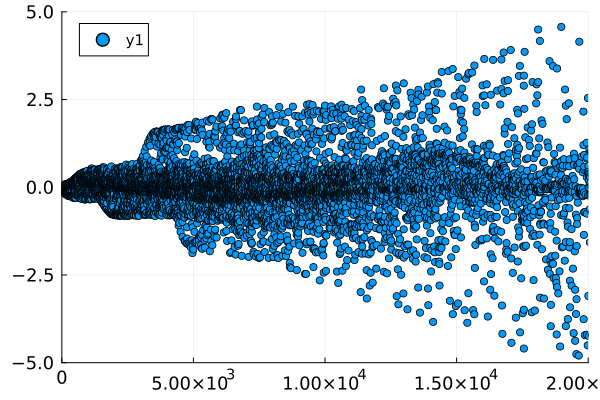

In [20]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
    xlimits=(0,20000),
    ylimits=(-5, 5)
)

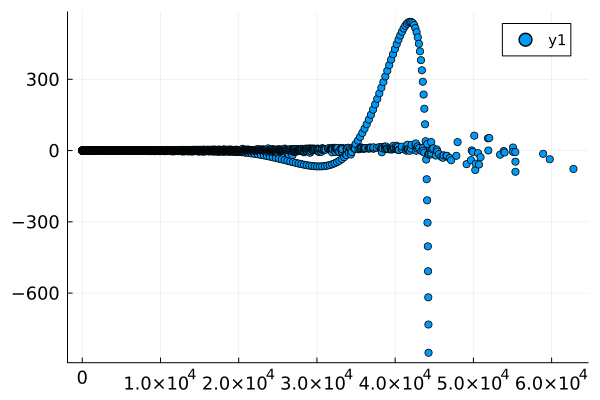

In [21]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
)